In [49]:
import scipy.io
import matplotlib.pyplot as plt

data = scipy.io.loadmat('Brain.mat')

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])

In [50]:
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)

(362, 434, 10)
(362, 434, 10)


In [51]:
# Max and min label
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

5
0


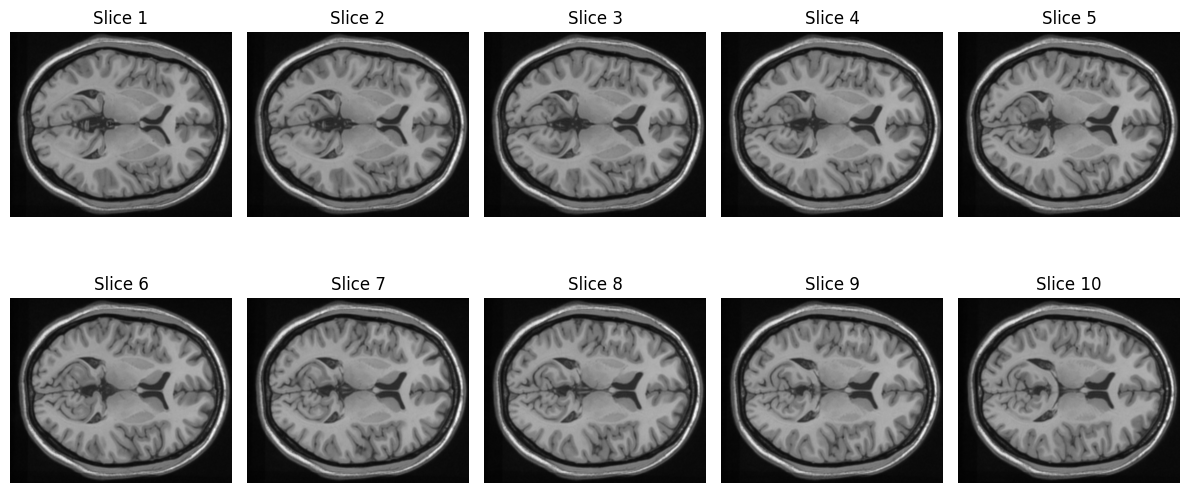

In [52]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_stacked[:, :, i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

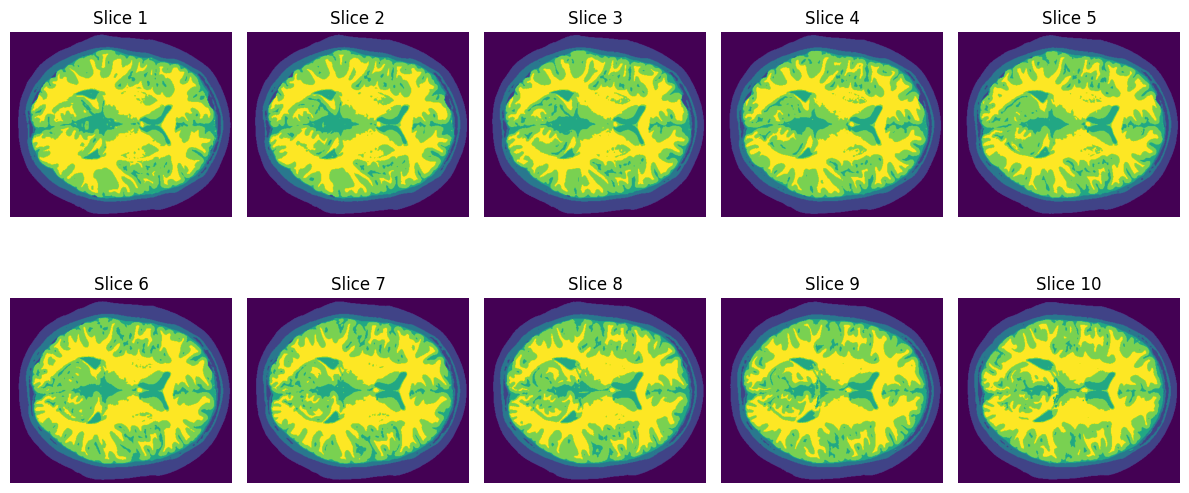

In [53]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_labels[:, :, i])
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

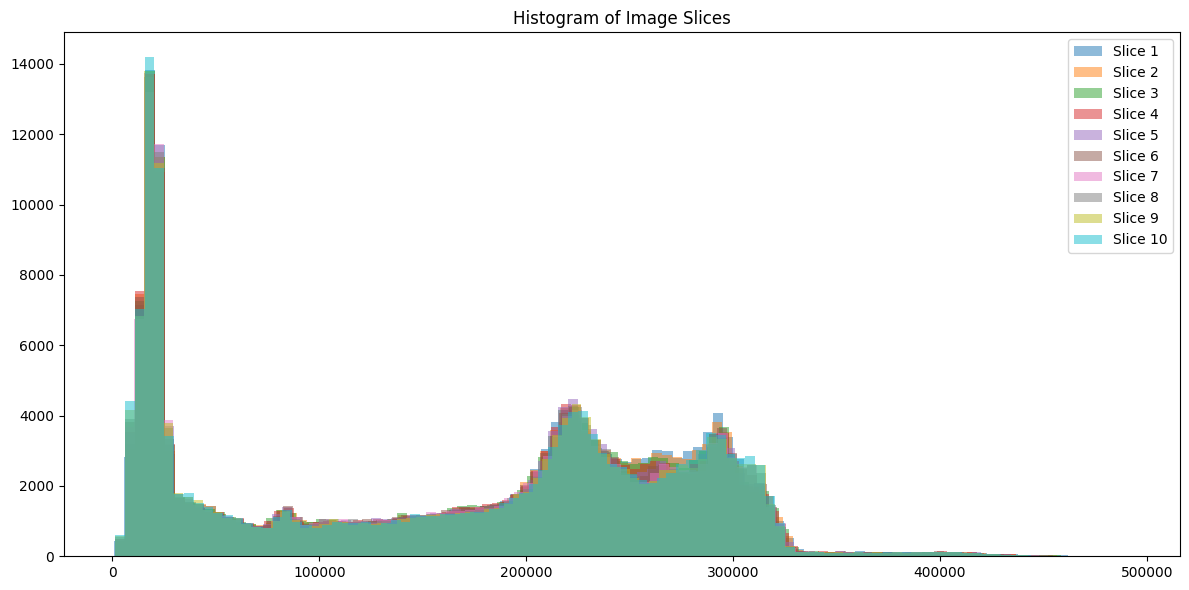

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(mri_stacked.shape[2]):
    hist = plt.hist(mri_stacked[:, :, i].flatten(), bins=100, alpha=0.5, label=f'Slice {i+1}')

ax.set_title('Histogram of Image Slices')
ax.legend()

plt.tight_layout()
plt.show()


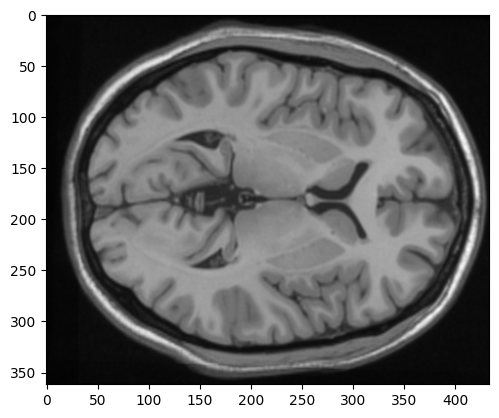

In [55]:
reference_img = mri_stacked[:,:,0]

# Normalize the reference image
reference_img = (reference_img - reference_img.min()) / (reference_img.max() - reference_img.min())

plt.imshow(reference_img, cmap='gray')

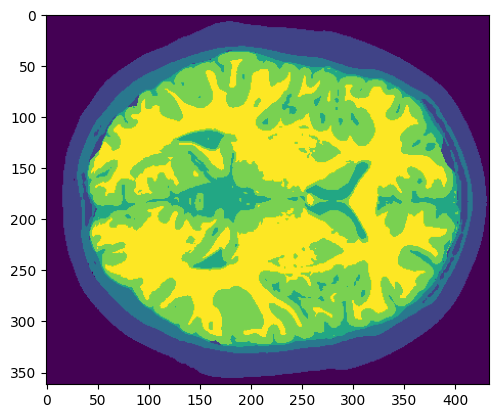

In [56]:
reference_labels = mri_labels[:,:,0]
plt.imshow(reference_labels)

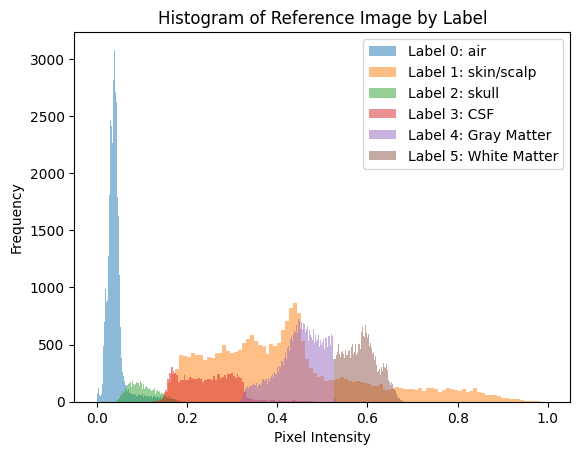

In [57]:
import numpy as np

# Flatten the reference_labels
labels_flat = reference_labels

# Label names
label_names = ['air', 'skin/scalp', 'skull', 'CSF', 'Gray Matter', 'White Matter']


# Initialize an empty list to store the histograms
histograms = []

# Iterate over unique labels
for label in np.unique(labels_flat):
    # Select the pixels with the current label
    pixels = reference_img[labels_flat == label]
    
    # Plot the histogram of the selected pixels
    hist = plt.hist(pixels.flatten(), bins=100, alpha=0.5, label=f'Label {label}: {label_names[label]}')
    
    # Append the histogram to the list
    histograms.append(hist)

# Show the legend
plt.legend()

# Set the title and labels
plt.title('Histogram of Reference Image by Label')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Show the plot
plt.show()


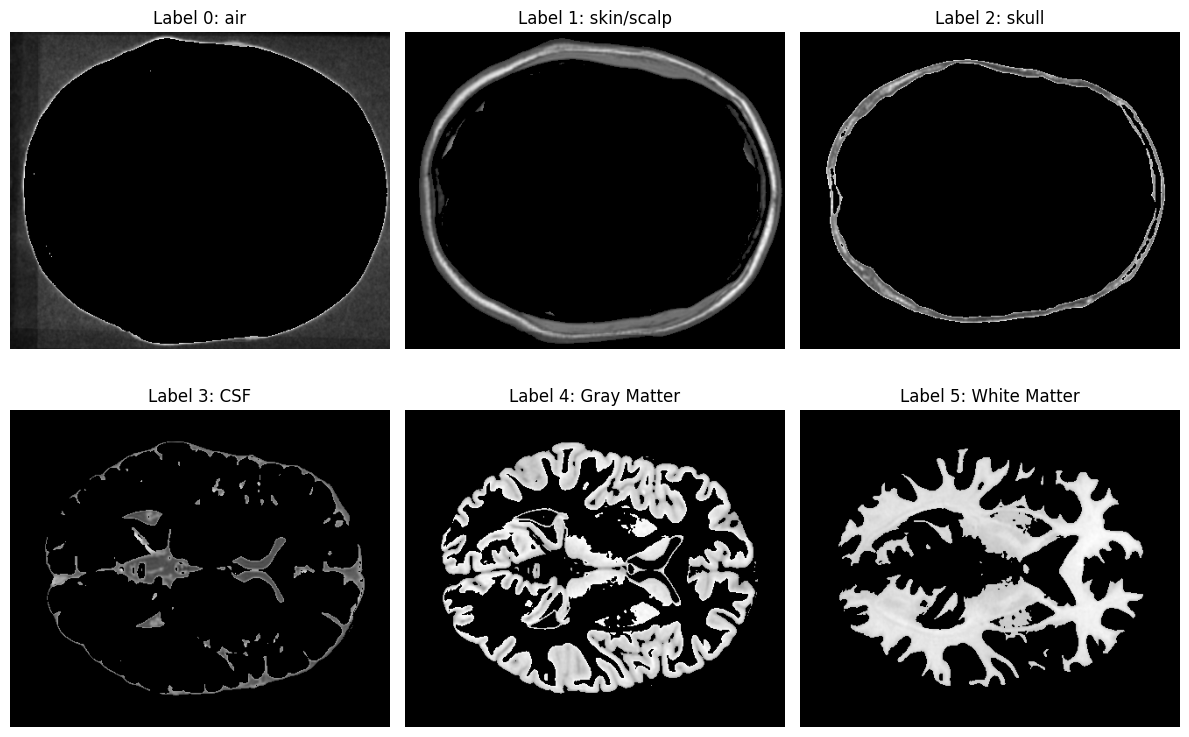

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = reference_img * (reference_labels == i)
    ax.imshow(mask.reshape(reference_img.shape), cmap='gray')
    ax.set_title(f'Label {i}: {label_names[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


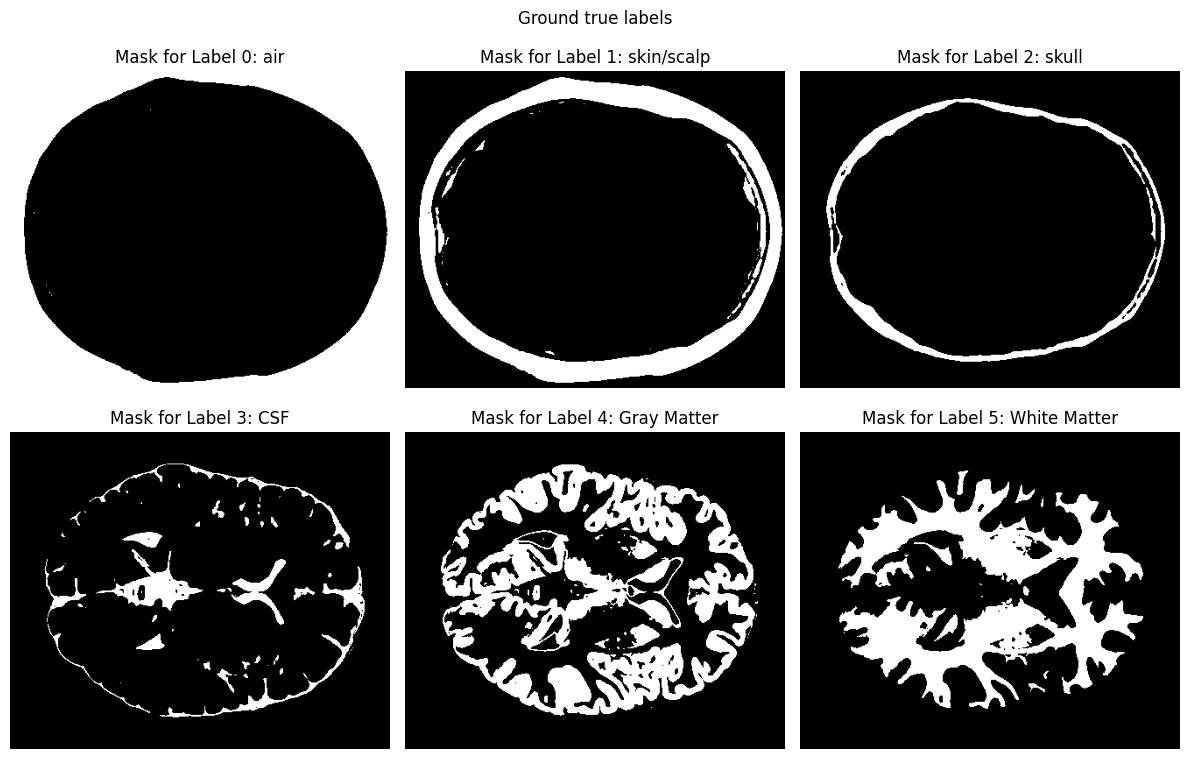

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(reference_labels == i, cmap='gray')
    ax.set_title(f'Mask for Label {i}: {label_names[i]}')
    ax.axis('off')

plt.suptitle("Ground true labels")
plt.tight_layout()
plt.show()


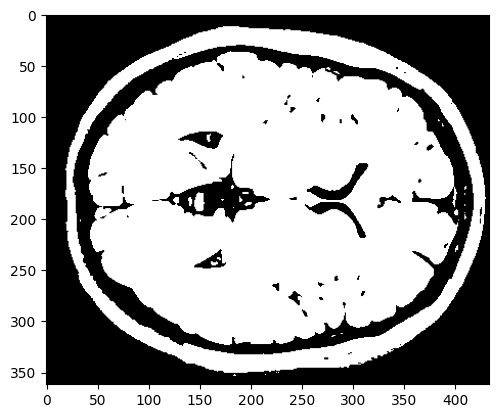

In [60]:
from skimage.filters import threshold_otsu

# 1. Apply an outsu algorithm to the reference image
threshold = threshold_otsu(reference_img)
binary = reference_img > threshold

# Plot the binary image
plt.imshow(binary, cmap='gray')

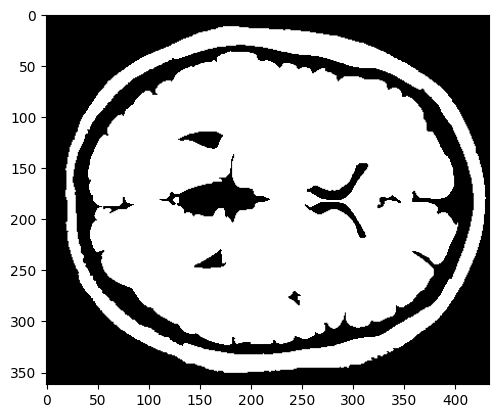

In [61]:
# 2. Remove the smaller artifict within each white or black region
from skimage.morphology import remove_small_objects, remove_small_holes

cleaned = remove_small_holes(binary)
cleaned = remove_small_objects(cleaned, min_size=1000)

# Plot the cleaned image
plt.imshow(cleaned, cmap='gray')

Number of labels: 2


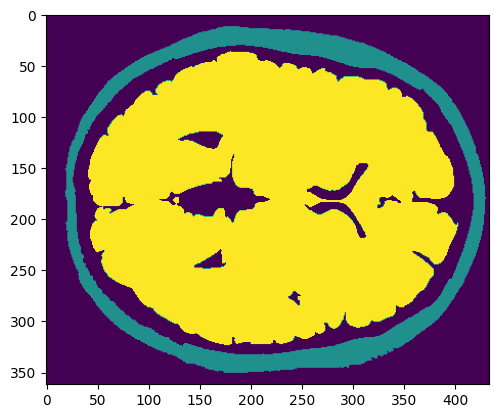

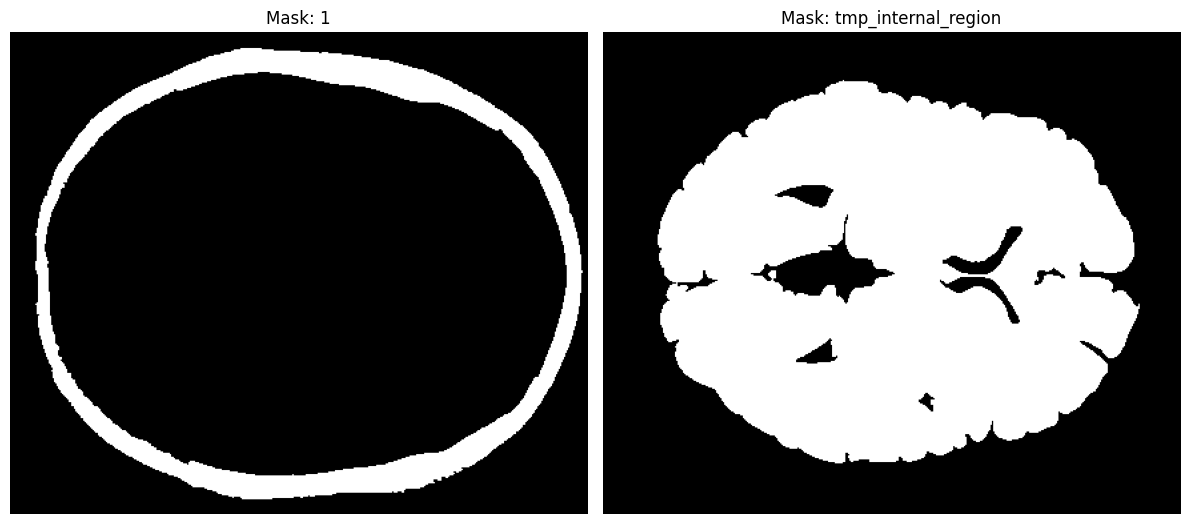

In [62]:
import scipy.ndimage as ndimage
from collections import OrderedDict

# NOTE: I can get one additional from the cleaned image
# In principel, I got 3, but I focus on the first label
# Apply two-pass algorithm to the cleaned image
labels, num_labels = ndimage.label(cleaned)

# Print the number of labels
print("Number of labels:", num_labels)

# Plot the labeled image
plt.imshow(labels)
plt.show()

# Array to save temporal mask per label
temporal_masks = OrderedDict()

# Keep only label 1 and change to type int
temporal_masks["1"] = (labels == 1).astype(int)
temporal_masks["tmp_internal_region"] = (labels == 2).astype(int)

# Plot temporal masks
def plot_masks(temporal_masks, rows=1, cols=2):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))

    flatten_axes = axes.flat
    for ax, (key, mask) in zip(flatten_axes, temporal_masks.items()):
        ax.imshow(mask, cmap='gray')
        ax.set_title(f'Mask: {key}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_masks(temporal_masks, 1, 2)

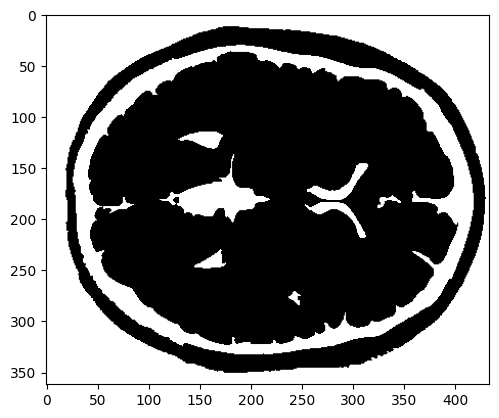

In [63]:
# 4. From cleaned image get four labels mask
# NOTE: I can get two mask 3 characteristic labels from the inverted cleaned image

# Invert the cleaned image
inverted = ~cleaned

# Plot the inverted image
plt.imshow(inverted, cmap='gray')

Number of labels: 10


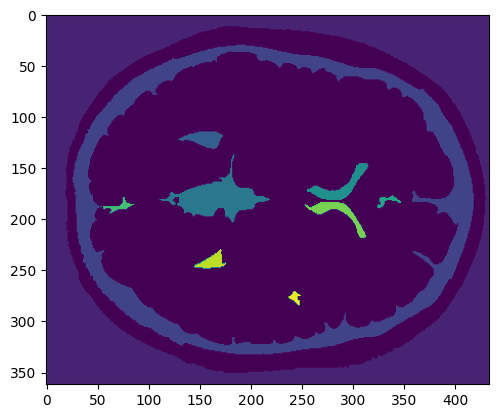

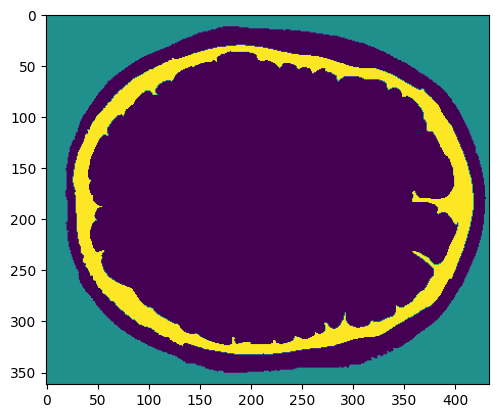

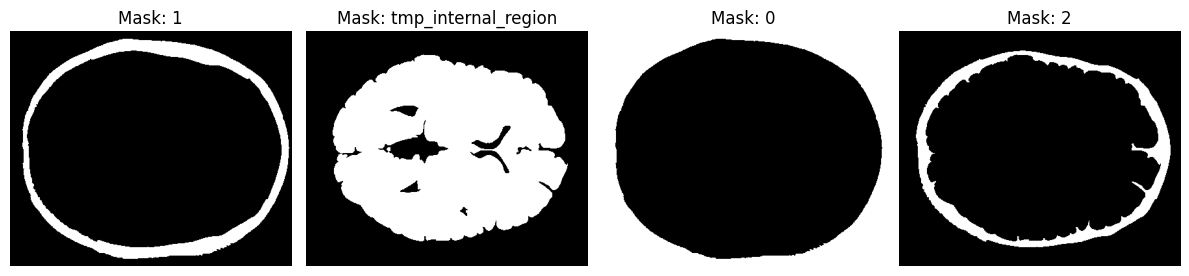

In [64]:
import scipy.ndimage as ndimage

# Apply two-pass algorithm to the inverted image
inverted_labels, num_labels = ndimage.label(inverted)

# Print the number of labels
print("Number of labels:", num_labels)

# Plot the labeled image
plt.imshow(inverted_labels)
plt.show()

# Only consider the two first labels and all the others as background
inverted_labels[inverted_labels > 2] = 0

plt.imshow(inverted_labels)
plt.show()

# Array to save temporal mask per label
temporal_masks["0"] = (inverted_labels == 1).astype(int)
temporal_masks["2"] = (inverted_labels == 2).astype(int)

# Plot temporal masks
plot_masks(temporal_masks, 1, 4)

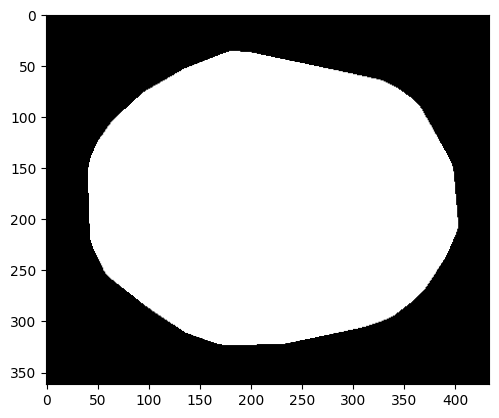

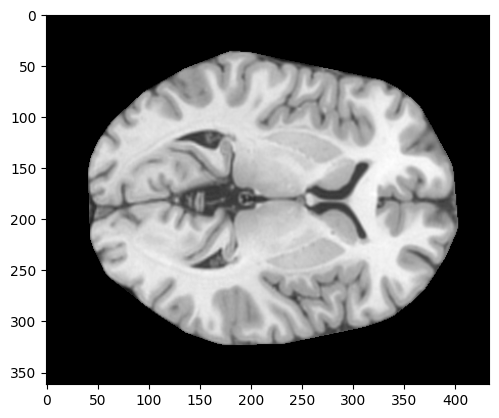

In [65]:
from skimage.morphology import convex_hull_image

# Apply the convex hull to the tmo_internal_region
convex_hull = convex_hull_image(temporal_masks["tmp_internal_region"])

# Erode a little bit the convex hull
# convex_hull = ndimage.binary_erosion(convex_hull, iterations=1)

# Plot the convex hull
plt.imshow(convex_hull, cmap='gray')
plt.show()

# Apply the convex hull to the mask1
masked_convex_hull = reference_img * convex_hull

# Plot the masked image
plt.imshow(masked_convex_hull, cmap='gray')
plt.show()

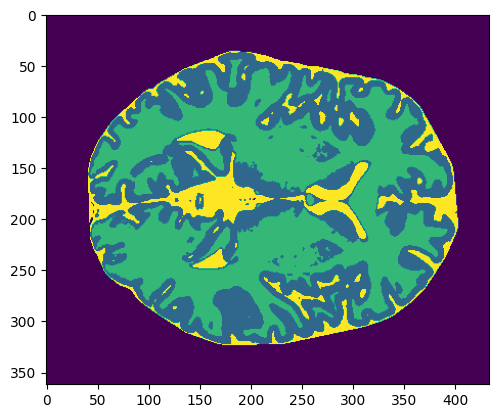

In [66]:
# Apply k-means clustering to the partial_reference image
from sklearn.cluster import KMeans

def kmeans_segmentation(image, n_clusters=4):
    # Reshape the image to a 2D array
    X = image.reshape(-1, 1)

    # Fit KMeans to the data
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

    # Predict the labels for the data
    labels = kmeans.predict(X)

    # Reshape the labels to the original image shape
    labels = labels.reshape(image.shape)

    return labels

# Reshape the image to a 2D array
X = masked_convex_hull.reshape(-1, 1)

# Fit KMeans to the data
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

# Predict the labels for the data
internal_labels = kmeans.predict(X)

# Reshape the labels to the original image shape
internal_labels = internal_labels.reshape(masked_convex_hull.shape)

# Plot the labels
plt.imshow(internal_labels)

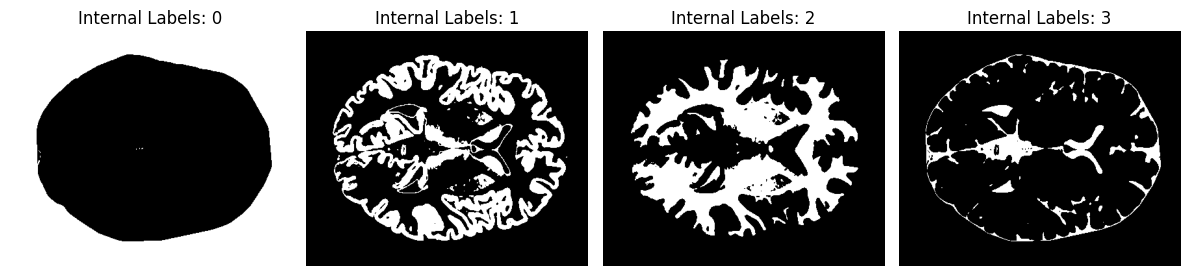

In [67]:
# Show each label separately
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    mask = internal_labels == i
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Internal Labels: {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [68]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Order the centroids and return the indices
order = np.argsort(centroids, axis=0)

# Use these order to fit the temporal_mask 3, 4, 5 with order[1:]
temporal_masks["3"] = (internal_labels == order[1]).astype(int)
temporal_masks["4"] = (internal_labels == order[2]).astype(int)
temporal_masks["5"] = (internal_labels == order[3]).astype(int)

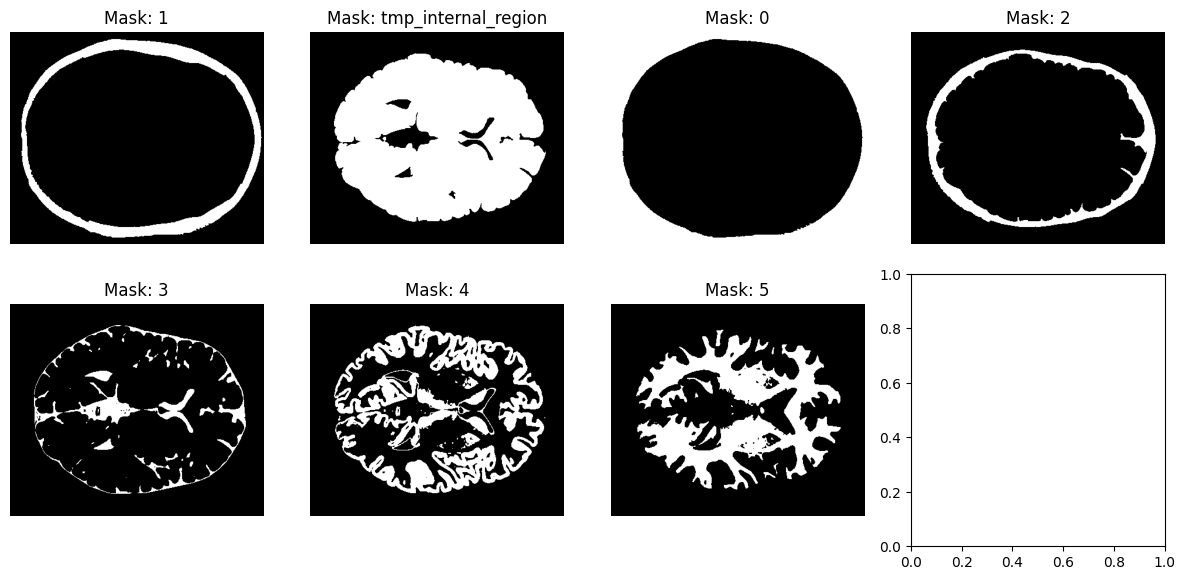

In [69]:
# Plot temporal masks
plot_masks(temporal_masks, 2, 4)

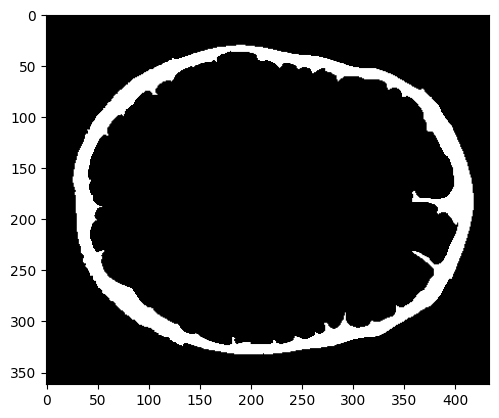

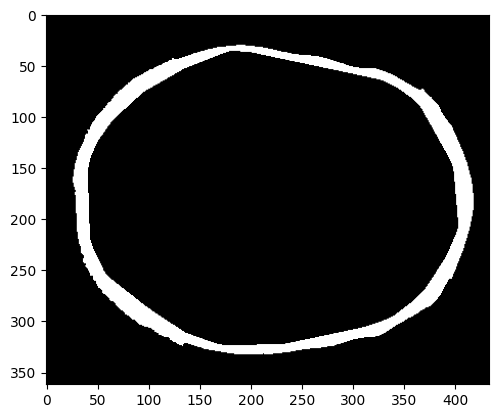

In [70]:
# Get the mask 2 and rest the interception between the mask 2 and the convex hull mask
temp_mask = temporal_masks["2"] - (temporal_masks["2"] * convex_hull)

# Plot mask 2
plt.imshow(temporal_masks["2"], cmap='gray')
plt.show()

# Plot mask 2 and convex hull together
plt.imshow(temp_mask, cmap='gray')
plt.show()


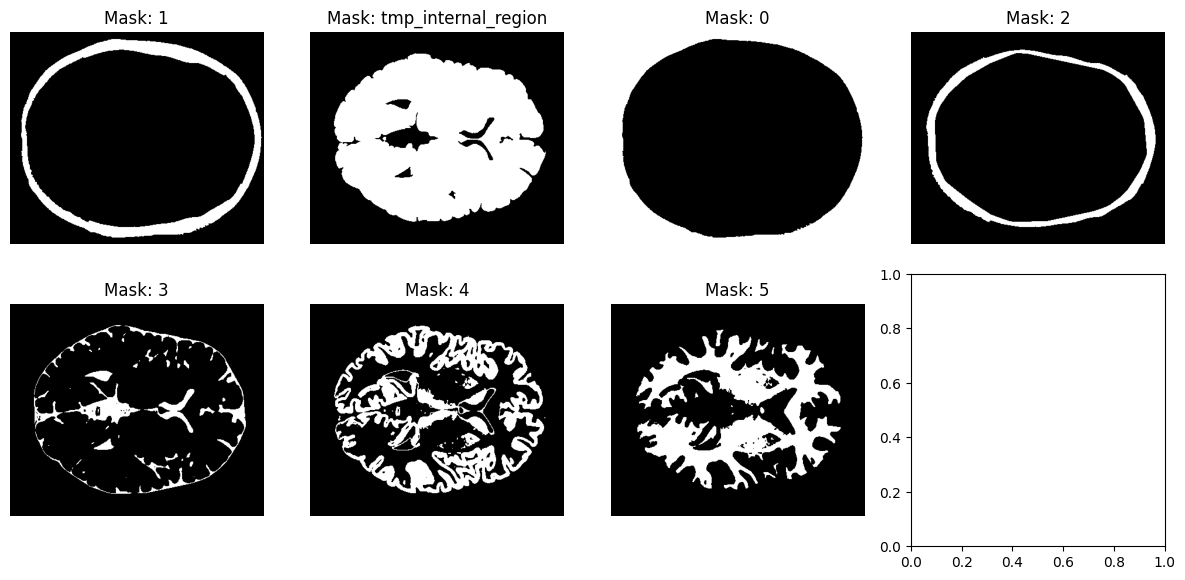

In [71]:
# Replace temporal mask 2 with the new mask
temporal_masks["2"] = temp_mask

# Plot temporal masks
plot_masks(temporal_masks, 2, 4)

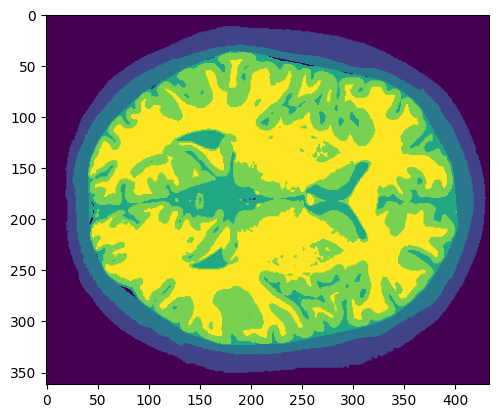

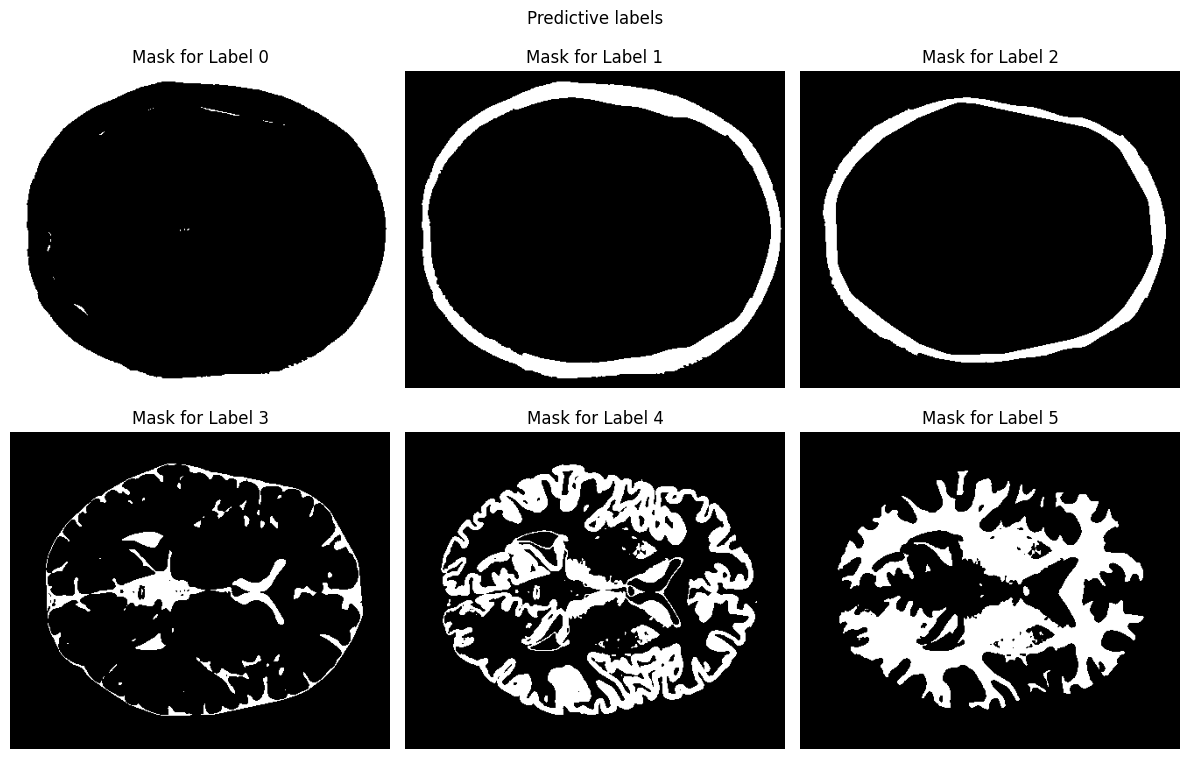

In [72]:
segmented_labels = np.zeros_like(reference_img)

# Accumulate all the temporal masks in the segmented_labels
for label in range(6):
    mask = temporal_masks[str(label)]
    segmented_labels[mask == 1] = label

# Plot the final mask
plt.imshow(segmented_labels)

# Show each label separately
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = segmented_labels == i
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')
plt.suptitle("Predictive labels")
plt.tight_layout()
plt.show()

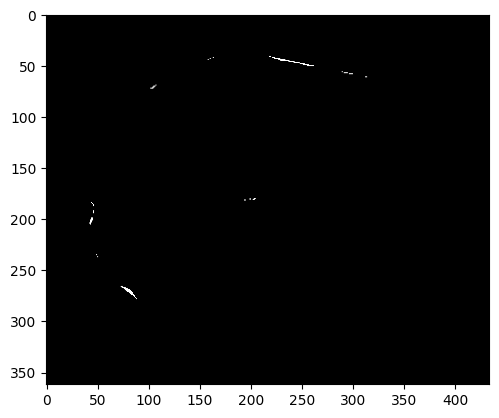

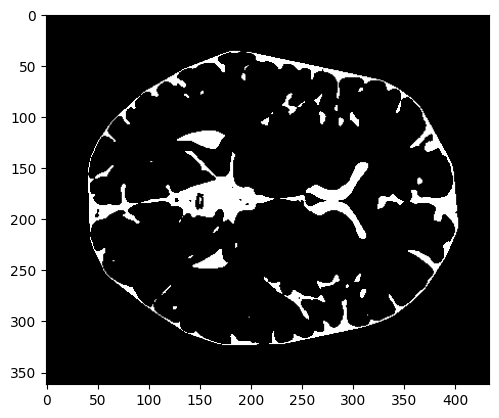

In [73]:
# # Add the background noise to the mask 3
temp_mask = segmented_labels.copy()
temp_mask[temporal_masks["0"]==1] = 7
temp_mask = temp_mask == 0

plt.imshow(temp_mask, cmap='gray')
plt.show()

# Plot the noise
plt.imshow(temp_mask.astype(int) + temporal_masks['3'], cmap='gray')
plt.show()

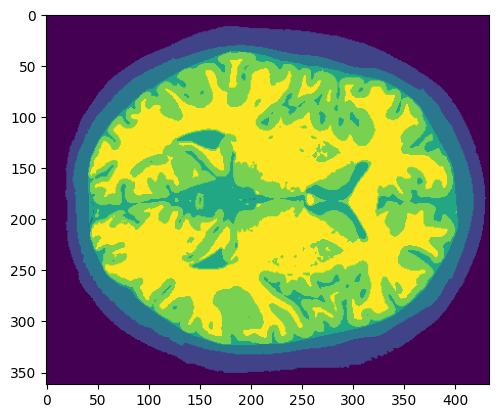

In [74]:
segmented_labels[temp_mask] = 2

# # Plot the final mask
plt.imshow(segmented_labels)
plt.show()

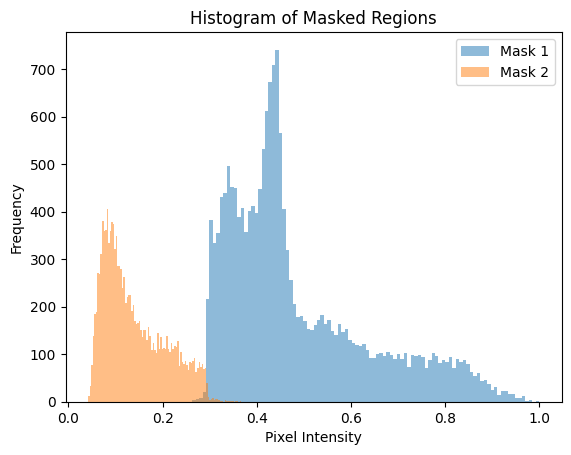

In [75]:
# Plot the histogram of masked regions temporal_masl["1"] and temporal_masl["2"]
histograms = []

for label in ["1", "2"]:
    pixels = reference_img[temporal_masks[label] == 1]
    hist = plt.hist(pixels.flatten(), bins=100, alpha=0.5, label=f'Mask {label}')
    histograms.append(hist)

plt.legend()
plt.title('Histogram of Masked Regions')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

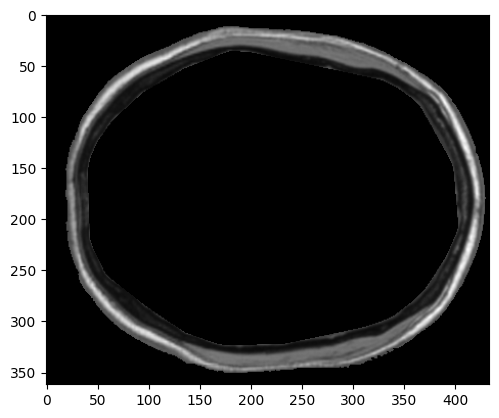

In [76]:
# Add the mask 1 and 2 in a tmp_mask
tmp_mask = temporal_masks["1"] + temporal_masks["2"]

# Apply tmp_mask to the reference image
tmp_masked = reference_img * tmp_mask

# Plot the masked image
plt.imshow(tmp_masked, cmap='gray')
plt.show()

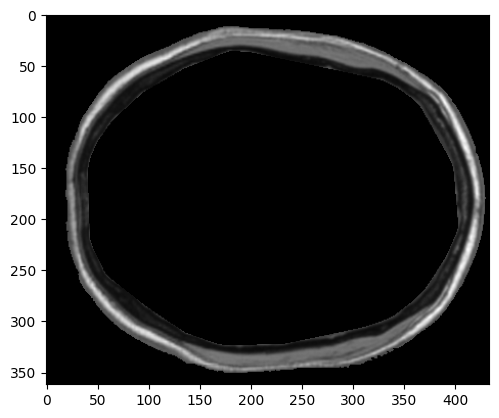

0.240234375


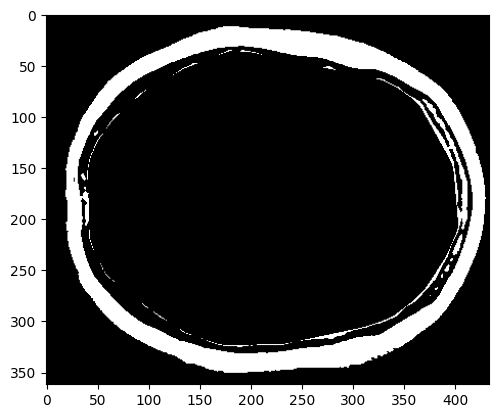

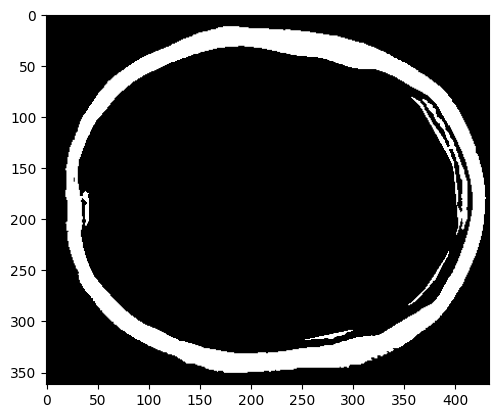

In [257]:
# Apply outsu algorithm to the masked image
threshold = threshold_otsu(tmp_masked)
binary = tmp_masked > threshold - 0.07
print(threshold)
# Plot the binary image
plt.imshow(binary, cmap='gray')
plt.show()

# Remove the smaller artifict within each white or black region
# cleaned = remove_small_holes(binary)
cleaned = remove_small_objects(binary, min_size=100)

# Plot the cleaned image
plt.imshow(cleaned, cmap='gray')
plt.show()

# Insert binary over the segmented image
# segmented_labels[binary] = 1

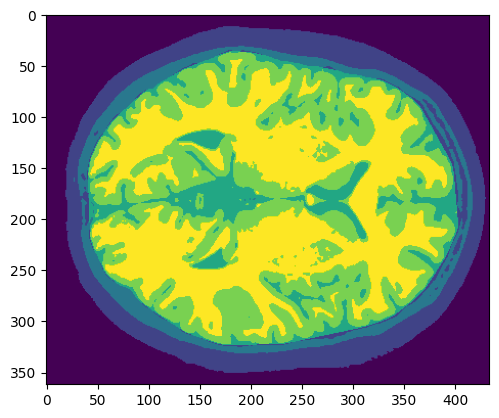

In [258]:
# Insert binary over the segmented image
segmented_labels[binary] = 1

# Plot the final mask
plt.imshow(segmented_labels)
plt.show()

In [259]:
# Print the number of pixels per label
for i in range(6):
    print(f"Label {i}: {np.sum(reference_labels == i)} pixels")

# NOTE: clearly we have an imbalance in the number of pixels per label

Label 0: 41630 pixels
Label 1: 24071 pixels
Label 2: 9093 pixels
Label 3: 9788 pixels
Label 4: 37858 pixels
Label 5: 34668 pixels


In [260]:
# segmented_labels is my prediction and reference_labels is the ground truth

from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import jaccard_score

# Flatten the arrays
y_true = reference_labels.flatten()
y_pred = segmented_labels.flatten()

# Compute the metrics
accuracy = accuracy_score(y_true, y_pred)
# Flatten the arrays
y_true = reference_labels.flatten()
y_pred = segmented_labels.flatten()


jaccard_index = jaccard_score(y_true, y_pred, average=None)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Compute micro metrics
micro_jaccard = jaccard_score(y_true, y_pred, average='micro')
micro_precision = precision_score(y_true, y_pred, average='micro')
micro_recall = recall_score(y_true, y_pred, average='micro')
micro_f1 = f1_score(y_true, y_pred, average='micro')

# Compute macro metrics
macro_jaccard = jaccard_score(y_true, y_pred, average='macro')
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

# Print the Jaccard Index
print("accuracy:", round(accuracy, 4))
print("Jaccard Index:", np.round(jaccard_index, 4))
print("Precision:", np.round(precision, 4))
print("Recall:", np.round(recall, 4))
print("F1 Score:", np.round(f1, 4), "\n")

print("Micro Jaccard Index:", round(micro_jaccard, 4))
print("Micro Precision:", round(micro_precision, 4))
print("Micro Recall:", round(micro_recall, 4))
print("Micro F1 Score:", round(micro_f1, 4), "\n")

print("Macro Precision:", round(macro_precision, 4))
print("Macro Recall:", round(macro_recall, 4))
print("Macro F1 Score:", round(macro_f1, 4))
print("Macro Jaccard Index:", round(macro_jaccard, 4))


accuracy: 0.9433
Jaccard Index: [0.9378 0.8263 0.9271 0.6991 0.8846 0.9474]
Precision: [0.9379 0.957  0.9498 0.7788 0.9881 0.9474]
Recall: [0.9998 0.8581 0.9749 0.8723 0.8942 1.    ]
F1 Score: [0.9679 0.9049 0.9622 0.8229 0.9388 0.973 ] 

Micro Jaccard Index: 0.8927
Micro Precision: 0.9433
Micro Recall: 0.9433
Micro F1 Score: 0.9433 

Macro Precision: 0.9265
Macro Recall: 0.9332
Macro F1 Score: 0.9283
Macro Jaccard Index: 0.8704


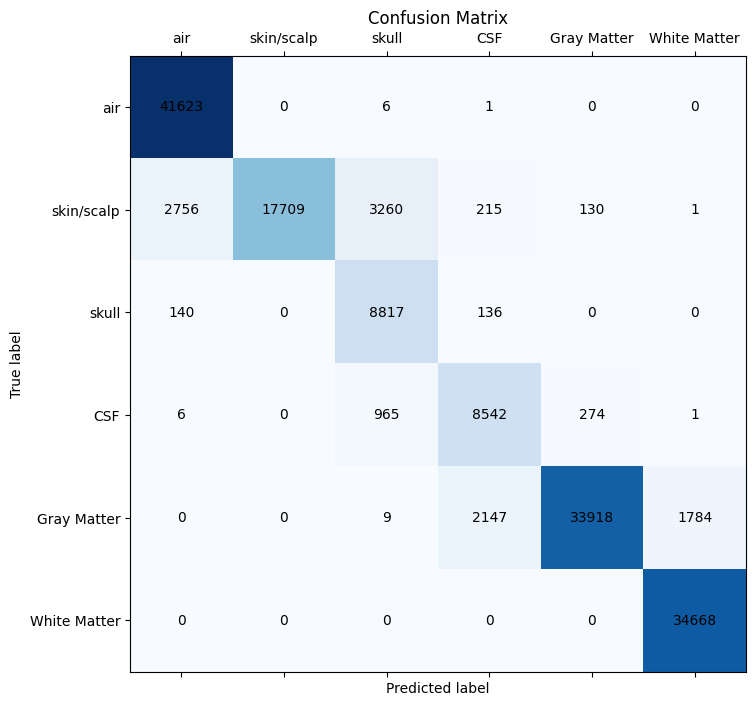

In [209]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap='Blues')

# Add the matrix values
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), va='center', ha='center')

# Set the title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Set the ticks
ax.set_xticks(range(6))
ax.set_yticks(range(6))

# Set the labels
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# Show the plot
plt.show()


- [IDEAS] Possible way to smooth the contours
- Smooth with dilatation or erotion

# First try to include the part of label 3
# Idea apply a KNN clustering only between labels 1 and 2
